In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import joblib
import pickle
import time
from copy import deepcopy
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
import xgboost as xgb

c:\Users\haile\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [13]:
#https://builtin.com/machine-learning/nlp-word2vec-python

In [8]:
df=pd.read_pickle('C:/Users/haile/OneDrive - University of Bristol/assessment2/data_cleaned_1')
df.head()

,score,text
0,3.0,"[good, helpfull, read, book, good, type, thats..."
1,1.0,"[sadly, overprice, irrelevant, spite, claim, i..."
2,2.0,"[endless, rant, howard, borrow, dennis, miller..."
3,1.0,"[not, quite, hip, really, shame, time, reserch..."
4,5.0,"[journey, centre, earth, hey, great, book, abs..."


In [113]:
vector_size=100
#The number of dimensions of embeddings, the default is 100
window=3
#The maximum distance between a target word and its neighbours, default is 5
min_count=3
#The minimum counts of words in order for the word to be considered for the training of model, default is 5
workers=3
#The number of partitions during training, default is 3
sg=1
#The training algorithom, either CBOW(0) or skip gram(1), default is CBOW

#tokens = pd.Series(df['tokenized_text']).values
start_t = time.time()
w2vmodel=Word2Vec(df['text'],min_count=min_count,vector_size=vector_size,workers=workers,sg=sg)
print('Time taken to train word2vec model:' +str(time.time()-start_t))

Time taken to train word2vec model:27.78731656074524


In [114]:
filename='w2v_model1.joblib'
joblib.dump(w2vmodel,filename)

['w2v_model1.joblib']

In [115]:
w2vmodel=joblib.load('w2v_model1.joblib')

In [116]:
word2vec_model_file = 'C:/Users/haile/OneDrive - University of Bristol/assessment2/data_cleaned_1' + 'word2vec_1' + '.model'
w2vmodel.save(word2vec_model_file)

In [117]:
w2v_model = Word2Vec.load(word2vec_model_file) #we have to save and load for some of the function below to work

In [118]:
w2v_model.wv.key_to_index

{'book': 0,
 'not': 1,
 'read': 2,
 'one': 3,
 'story': 4,
 'quot': 5,
 'like': 6,
 'time': 7,
 'would': 8,
 'great': 9,
 'make': 10,
 'good': 11,
 'write': 12,
 'get': 13,
 'well': 14,
 'character': 15,
 'love': 16,
 'find': 17,
 'life': 18,
 'think': 19,
 'the': 20,
 'novel': 21,
 'first': 22,
 'many': 23,
 'know': 24,
 'much': 25,
 'work': 26,
 'people': 27,
 'way': 28,
 'also': 29,
 'take': 30,
 'even': 31,
 'give': 32,
 'year': 33,
 'really': 34,
 'could': 35,
 'say': 36,
 'author': 37,
 'world': 38,
 'see': 39,
 'want': 40,
 'end': 41,
 'reader': 42,
 'come': 43,
 'best': 44,
 'use': 45,
 'thing': 46,
 'go': 47,
 'new': 48,
 'look': 49,
 'page': 50,
 'little': 51,
 'two': 52,
 'never': 53,
 'recommend': 54,
 'seem': 55,
 'man': 56,
 'enjoy': 57,
 'tell': 58,
 'still': 59,
 'ever': 60,
 'old': 61,
 'this': 62,
 'child': 63,
 'part': 64,
 'must': 65,
 'live': 66,
 'feel': 67,
 'start': 68,
 'series': 69,
 'and': 70,
 'woman': 71,
 'need': 72,
 'day': 73,
 'every': 74,
 'back': 75,


### load pretrained model 

In [95]:
from gensim.models import KeyedVectors

pretrained_path = "C:/Users/haile/OneDrive - University of Bristol/assessment2/glove_model2.txt"
model_2 = KeyedVectors.load_word2vec_format(pretrained_path, binary=False)
model_2.save('C:/Users/haile/OneDrive - University of Bristol/assessment2/glove_model.model')


In [119]:
#model = Word2Vec(vector_size=100, min_count=1)
w2v_model.build_vocab([list(model_2.index_to_key)], update=True)

In [125]:

training_examples_count = w2v_model.corpus_count
w2v_model.train(df['text'],total_examples=training_examples_count, epochs=w2v_model.epochs)


(18098531, 20081575)

https://towardsdatascience.com/word2vec-explained-49c52b4ccb71

how to put the outputs of word2vec into data frame, and apply PCA on the outputs

In [126]:
emb_df = (
    pd.DataFrame(
        [w2v_model.wv.get_vector(str(n)) for n in w2vmodel.wv.key_to_index],
        index = w2vmodel.wv.key_to_index
    )
)
print(emb_df.shape)

emb_df.head()

(36738, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
book,0.159897,0.446531,0.193733,0.171833,-0.168209,0.011781,0.194706,0.306017,-0.362828,-0.302143,...,0.015648,0.018295,-0.044424,-0.140301,0.530423,0.179241,-0.105242,0.089344,-0.068826,0.224026
not,-0.057648,0.376069,0.233399,0.049189,-0.053777,-0.251238,0.323133,0.444645,-0.107316,-0.315226,...,0.444007,-0.095590,0.015871,-0.100124,0.351453,0.299043,-0.024236,-0.017444,-0.219344,0.059689
read,-0.083642,0.414169,0.327875,0.017268,-0.028621,-0.071050,0.355501,0.293664,-0.410612,-0.506055,...,0.201195,-0.241134,0.012516,-0.223860,0.319788,0.294548,0.127970,0.148626,-0.001360,0.055663
one,0.071698,0.564244,0.085955,0.195965,-0.002936,-0.050000,-0.026133,0.424163,0.070053,-0.429337,...,0.128074,0.010254,-0.104710,-0.258344,0.571458,0.200598,0.199688,-0.164173,0.081466,-0.066718
story,-0.062988,0.274261,-0.095302,0.308135,0.229901,0.043316,-0.105754,0.788721,-0.425252,-0.488860,...,0.032930,-0.282237,-0.095458,-0.328511,0.079491,-0.107206,0.072664,0.341601,-0.076524,0.405122


In [127]:
print(w2v_model.wv.most_similar('wonderful'))

[('wonderfull', 0.8339987993240356), ('fabulous', 0.821222186088562), ('fantastic', 0.8117764592170715), ('splendid', 0.8047893643379211), ('amazing', 0.7656024098396301), ('terrific', 0.7541052103042603), ('nesbit', 0.7526402473449707), ('great', 0.7506873607635498), ('excellent', 0.744554340839386), ('gail', 0.744245171546936)]


In [128]:
print("Cosine similarity between 'wonderful' " +
               "terrible' - Skip Gram : ",
    w2v_model.wv.similarity('wonderful', 'bad'))

Cosine similarity between 'wonderful' terrible' - Skip Gram :  0.3421024


[]

<Figure size 640x480 with 0 Axes>

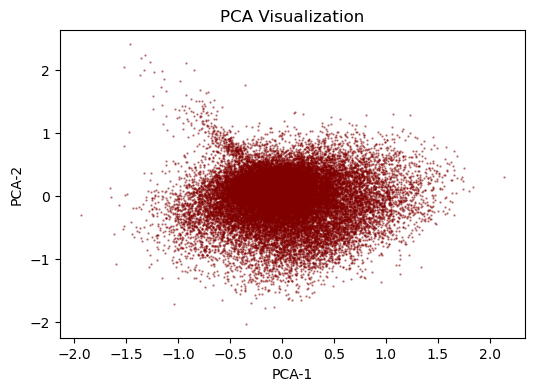

In [ ]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)

plt.clf()
fig = plt.figure(figsize=(6,4))

plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)

plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()

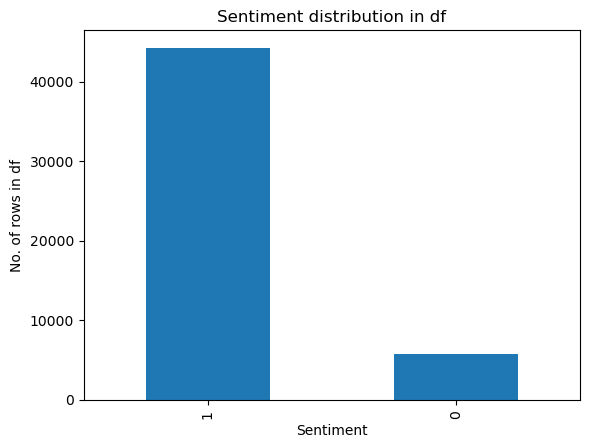

In [20]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return 0
    else:
        return 1
# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['score']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()


In [21]:
def split_train_test(df, test_size=0.2, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df['text'], 
                                                        df['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

In [22]:
X_train, X_test, y_train, y_test = split_train_test(df)

Value counts for Train sentiments
1    35376
0     4624
Name: sentiment, dtype: int64
Value counts for Test sentiments
1    8859
0    1141
Name: sentiment, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
   index                                               text
0  45570  [multidimensional, thought, book, good, job, p...
1  21855  [magnetic, influence, success, business, find,...
2  41127  [read, weep, world, full, bad, book, write, am...
3   4849  [clear, channel, watt, book, great, show, book...
4  20742  [page, miss, line, mass, market, paperback, ed...


In [23]:
X_train.to_pickle('C:/Users/haile/OneDrive - University of Bristol/assessment2/X_train')
X_test.to_pickle('C:/Users/haile/OneDrive - University of Bristol/assessment2/X_test')
y_train.to_pickle('C:/Users/haile/OneDrive - University of Bristol/assessment2/y_train')
y_test.to_pickle('C:/Users/haile/OneDrive - University of Bristol/assessment2/y_test')

In [129]:
X_train=pd.read_pickle('C:/Users/haile/OneDrive - University of Bristol/assessment2/X_train')
X_test=pd.read_pickle('C:/Users/haile/OneDrive - University of Bristol/assessment2/X_test')
y_train=pd.read_pickle('C:/Users/haile/OneDrive - University of Bristol/assessment2/y_train')
y_test=pd.read_pickle('C:/Users/haile/OneDrive - University of Bristol/assessment2/y_test')

https://www.kaggle.com/code/varun08/sentiment-analysis-using-word2vec/notebook
 define functions to calculate feature vectors

In [100]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index_to_key)
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
    
    if nwords ==0:
        featureVec = np.zeros(1000)
        #avoiding divide by zero, define it as a all zero vector
    else:
        featureVec = np.divide(featureVec, nwords)
    # Dividing the result by number of words to get average

    return featureVec

In [101]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Comment %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
            
        counter = counter+1
        
    return reviewFeatureVecs

In [102]:
trainDataVecs = getAvgFeatureVecs(X_train['text'], w2v_model, 1000)

Comment 0 of 40000
Comment 1000 of 40000
Comment 2000 of 40000
Comment 3000 of 40000
Comment 4000 of 40000
Comment 5000 of 40000
Comment 6000 of 40000
Comment 7000 of 40000
Comment 8000 of 40000
Comment 9000 of 40000
Comment 10000 of 40000
Comment 11000 of 40000
Comment 12000 of 40000
Comment 13000 of 40000
Comment 14000 of 40000
Comment 15000 of 40000
Comment 16000 of 40000
Comment 17000 of 40000
Comment 18000 of 40000
Comment 19000 of 40000
Comment 20000 of 40000
Comment 21000 of 40000
Comment 22000 of 40000
Comment 23000 of 40000
Comment 24000 of 40000
Comment 25000 of 40000
Comment 26000 of 40000
Comment 27000 of 40000
Comment 28000 of 40000
Comment 29000 of 40000
Comment 30000 of 40000
Comment 31000 of 40000
Comment 32000 of 40000
Comment 33000 of 40000
Comment 34000 of 40000
Comment 35000 of 40000
Comment 36000 of 40000
Comment 37000 of 40000
Comment 38000 of 40000
Comment 39000 of 40000


In [26]:
trainDataVecs

array([[ 0.14034273, -0.02289204,  0.04288249, ..., -0.06831314,
        -0.00203111, -0.01395326],
       [ 0.12987085, -0.01425098,  0.05900474, ..., -0.04281596,
        -0.00029992, -0.04611236],
       [ 0.10155985, -0.01377982,  0.02490406, ..., -0.09436086,
         0.03176169, -0.05752936],
       ...,
       [ 0.18298995, -0.0046916 , -0.03151794, ..., -0.08164315,
         0.02932207, -0.01730692],
       [ 0.16090125,  0.00254819,  0.01224033, ..., -0.11253697,
         0.03710324, -0.03368711],
       [ 0.18173517,  0.00423707, -0.03346983, ..., -0.11452925,
         0.10254453, -0.01477751]], dtype=float32)

In [103]:
trainDataVecs.dump('C:/Users/haile/OneDrive - University of Bristol/assessment2/trainDataVecs')

In [104]:
trainDataVecs=pd.read_pickle('C:/Users/haile/OneDrive - University of Bristol/assessment2/trainDataVecs')

In [105]:
y_train.reset_index()

,level_0,index,sentiment
0,0,45570,1
1,1,21855,1
2,2,41127,0
3,3,4849,1
4,4,20742,0
...,...,...,...
39995,39995,39296,1
39996,39996,49015,1
39997,39997,2693,1
39998,39998,8076,1


In [106]:
def remove_unuseful_rows(trainDataVecs,y_train):
    list=[]
    for i in range(trainDataVecs.shape[0]):
        if np.all(trainDataVecs[i,]==0):
            list.append(i)
    if len(list)!=0:
        trainDataVecs=np.delete(trainDataVecs,list,axis=0)
        y_train.drop(index=list,inplace=True)
    return trainDataVecs,y_train
# remove the sample with all zero vector and its corresponding y

In [107]:
trainDataVecs1,y_train1=remove_unuseful_rows(trainDataVecs,y_train)

In [35]:
y_train1.shape

(39999, 2)

In [33]:
trainDataVecs1.shape

(39999, 1000)

In [36]:
y_train1

,index,sentiment
0,45570,0
1,21855,0
2,41127,0
3,4849,0
4,20742,0
...,...,...
39995,39296,0
39996,49015,0
39997,2693,0
39998,8076,0


In [108]:
y_train1=y_train1.reset_index(drop=True)

In [130]:
xgb_model = xgb.XGBClassifier(
    max_depth = 9, 
    min_child_weight = 1, 
    gamma = 0.4, 
    subsample=0.9, 
    colsample_bytree = 0.9,
    learning_rate =0.2,
    n_estimators=300)


start_time = time.time()
xgb_model.fit(trainDataVecs1, y_train1["sentiment"])
print("Time taken to fit the demodel with word2vec vectors: " + str(time.time() - start_time))

c:\Users\haile\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:02:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken to fit the demodel with word2vec vectors: 396.1837809085846


https://xgboost.readthedocs.io/en/stable/python/python_api.html
information about xgboost

In [64]:
filename='xgb_model1.joblib'
joblib.dump(xgb_model,filename)

['xgb_model1.joblib']

In [65]:
xgb_model=joblib.load('xgb_model1.joblib')

## Test data set

In [66]:
testDataVecs = getAvgFeatureVecs(X_test['text'], w2v_model, 1000)

Comment 0 of 10000
Comment 1000 of 10000
Comment 2000 of 10000
Comment 3000 of 10000
Comment 4000 of 10000
Comment 5000 of 10000
Comment 6000 of 10000
Comment 7000 of 10000
Comment 8000 of 10000
Comment 9000 of 10000


In [51]:
y_test=y_test.reset_index(drop=True)

In [46]:
y_test.head()

,index,sentiment
0,35514,0
1,11006,0
2,13463,0
3,48119,0
4,36625,0


In [67]:
testDataVecs1,y_test1=remove_unuseful_rows(testDataVecs,y_test)

In [49]:
forest_prediction=forest.predict(testDataVecs1)

In [68]:
xgb_prediction=xgb_model.predict(testDataVecs1)

In [51]:
np.dot(forest_prediction-y_test1['sentiment'],forest_prediction-y_test1['sentiment'])

1534

In [69]:
np.dot(xgb_prediction-y_test1['sentiment'],xgb_prediction-y_test1['sentiment'])

827

In [70]:
print(classification_report(y_test['sentiment'],forest_prediction))

NameError: name 'forest_prediction' is not defined

In [131]:
print(classification_report(y_test['sentiment'],xgb_prediction))

              precision    recall  f1-score   support

           0       0.74      0.42      0.54      1141
           1       0.93      0.98      0.95      8859

    accuracy                           0.92     10000
   macro avg       0.84      0.70      0.75     10000
weighted avg       0.91      0.92      0.91     10000



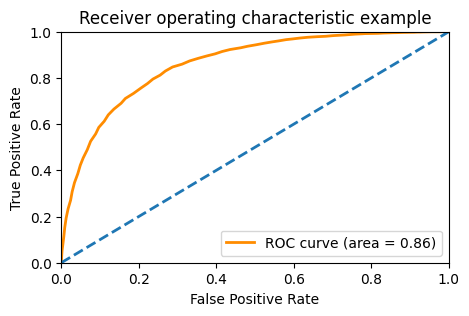

In [55]:
y_pred = [x[1] for x in forest.predict_proba(testDataVecs1)]
fpr, tpr, thresholds = roc_curve(y_test['sentiment'], y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (5, 3))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

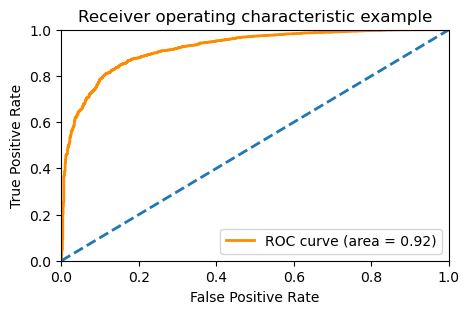

In [132]:
y_pred = [x[1] for x in xgb_model.predict_proba(testDataVecs1)]
fpr, tpr, thresholds = roc_curve(y_test['sentiment'], y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (5, 3))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Grid Test

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

In [80]:
#params = deepcopy(default_params)

param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5,7,9,11],
        'learning_rate': [0.2,0.05]
        }

In [84]:
estimator = xgb.XGBClassifier(n_estimators=300, objective='binary:logistic')

In [67]:
trainDataVecs1.shape

(39999, 1000)

In [73]:
y_train1['sentiment'].values

array([1, 1, 0, ..., 1, 1, 1])

In [87]:
eval_set = [(trainDataVecs1,y_train1['sentiment'].values)]
model = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, scoring="neg_log_loss")

start_time = time.time()

model.fit(trainDataVecs1,y_train1['sentiment'].values, verbose=0)

print("Time taken for random search: " + str(time.time() - start_time))

In [ ]:
model.dump('Data\grid_search')

In [ ]:
model=pd.read_pickle('Data\grid_search')

In [ ]:
print(model.best_params_)

# Doc2Vec


In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train['text'])]
print(documents[1])

In [ ]:
start_t = time.time()
doc2vec_model = Doc2Vec(documents, vector_size=1000, window=3, min_count=1, workers=4)
print('Time taken to train word2vec model:' +str(time.time()-start_t))

In [ ]:
filename='d2v_model.joblib'
joblib.dump(doc2vec_model,filename)

In [ ]:
vector = doc2vec_model.infer_vector(X_train['text'][0])
print(len(vector))
print("Top 10 values in Doc2Vec inferred vector:")
print(vector[:10])

In [ ]:
doc2vec_df = pd.read_csv(doc2vec_filename)

In [ ]:
clf_decision_doc2vec = DecisionTreeClassifier()
# Fit the model
clf_decision_doc2vec.fit(doc2vec_df, y_train['score'])

https://www.kaggle.com/code/nitin194/twitter-sentiment-analysis-word2vec-doc2vec